# Assignment 1 : Transfer learning using EfficientNet50 and with group's image data
## Importing necessary Libraries

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import cv2
import numpy as np
from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix,classification_report,f1_score,accuracy_score,precision_score,recall_score
import seaborn as sns
from keras import Sequential
from keras.layers import Dense,Flatten,Conv2D,MaxPooling2D,Dropout
from keras.applications.resnet50 import ResNet50

## GPU Config

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
print(f"GPUs available: {len(gpus)}")

GPUs available: 1


In [3]:
imgSize=256
trainDataPath = "/kaggle/input/grpimgdata/PreprocessedImg/Train"
testDataPath = "/kaggle/input/grpimgdata/PreprocessedImg/Test"
labels = ["Tishad","Touhid","Abir","Shimla"]

## Data Loading

In [4]:
def loadData(dataPath,labels,imgSize):
    data = []
    for label in labels:
        classPath = os.path.join(dataPath,label)
        classNum = labels.index(label)
        for img in tqdm(os.listdir(classPath),desc=f"Loading {label}"):
            try:
                imgPath = os.path.join(classPath,img)
                imgArray = cv2.imread(imgPath)
                imgArray = cv2.cvtColor(imgArray,cv2.COLOR_BGR2RGB)
                imgResized = cv2.resize(imgArray,(imgSize,imgSize))
                data.append([imgResized,classNum])
            except Exception as e:
                print(f"Error loading image {img}: {e}")
                
    shuffle(data)
    return data

In [5]:
trainData = loadData(trainDataPath,labels,imgSize)

Loading Shimla: 100%|██████████| 2000/2000 [00:06<00:00, 287.69it/s]


## Data Preprocessing

In [6]:
xTrain,yTrain = zip(*trainData)
xTrain = np.array(xTrain,dtype=np.float32)/255.0
yTrain = np.array(yTrain)

## Showing sample images with labels

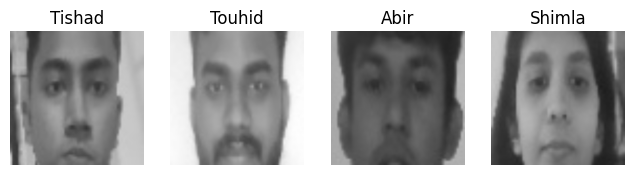

In [7]:
plt.figure(figsize=(10, 5))
unique_labels = set()
count = 0
for i in range(len(xTrain)):
    if yTrain[i] not in unique_labels:
        plt.subplot(1, 5, count + 1)
        plt.imshow(xTrain[i])
        plt.title(labels[yTrain[i]])
        plt.axis('off')
        unique_labels.add(yTrain[i])
        count += 1
    if count == 5:
        break
plt.show()

## Using EfficientNet50 as base Model

In [8]:
convBase = ResNet50(weights='imagenet',include_top=False,input_shape=(imgSize, imgSize, 3))
convBase.trainable = False

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


## Customly defined model

In [9]:
x = Conv2D(64, (3, 3), activation='relu', padding='same')(convBase.output)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Flatten()(x)
x = Dense(43, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(len(labels), activation='softmax')(x)

In [10]:
model = tf.keras.Model(inputs=convBase.input, outputs=x)

## Overall Model Summary

In [11]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 262, 262, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 128, 128, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 128, 128, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 128, 128, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 130, 130, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 64, 64, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 64, 64, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 64, 64, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 64, 64, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 64, 64, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 64, 64, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 64, 64, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 64, 64, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 64, 64, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 24,863,515 (94.85 MB)

 Trainable params: 1,275,803 (4.87 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [12]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

## Training

In [13]:
history = model.fit(
    xTrain, yTrain,
    epochs=100,
    validation_split=0.2,
    batch_size=32,
)

Epoch 1/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 33s 106ms/step - accuracy: 0.3128 - loss: 1.5038 - val_accuracy: 0.0000e+00 - val_loss: 2.3151
Epoch 2/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 15s 72ms/step - accuracy: 0.3096 - loss: 1.2943 - val_accuracy: 0.0000e+00 - val_loss: 2.1649
Epoch 3/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 15s 73ms/step - accuracy: 0.3433 - loss: 1.2670 - val_accuracy: 0.0000e+00 - val_loss: 2.0451
Epoch 4/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 15s 73ms/step - accuracy: 0.4871 - loss: 1.0898 - val_accuracy: 0.1269 - val_loss: 1.4502
Epoch 5/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 15s 73ms/step - accuracy: 0.5717 - loss: 0.9417 - val_accuracy: 0.0175 - val_loss: 1.3765
Epoch 6/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 14s 72ms/step - accuracy: 0.6162 - loss: 0.8405 - val_accuracy: 0.6019 - val_loss: 1.0594
Epoch 7/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 14s 72ms/step - accuracy: 0.6801 - loss: 0.7329 - val_accuracy: 0.2881 - val_loss: 1.2554
Epoch 8/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 15s 72ms/step - accuracy: 0.7

## Accuracy and Loss graph

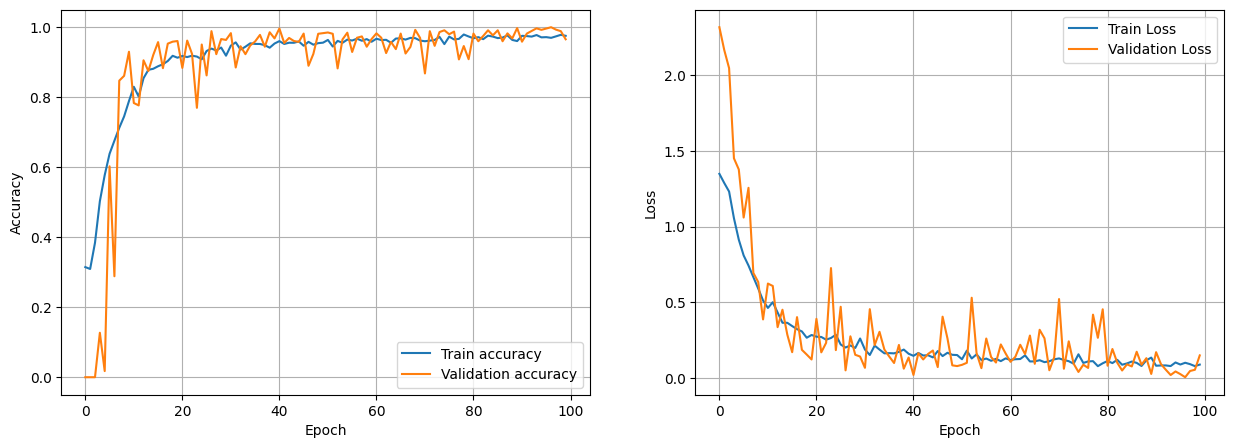

In [16]:
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'],label='Train accuracy')
plt.plot(history.history['val_accuracy'],label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.show()

## Saving model

In [17]:
model.save("transferLearningModel.h5")

## Showing confusion matrix

250/250 ━━━━━━━━━━━━━━━━━━━━ 15s 47ms/step


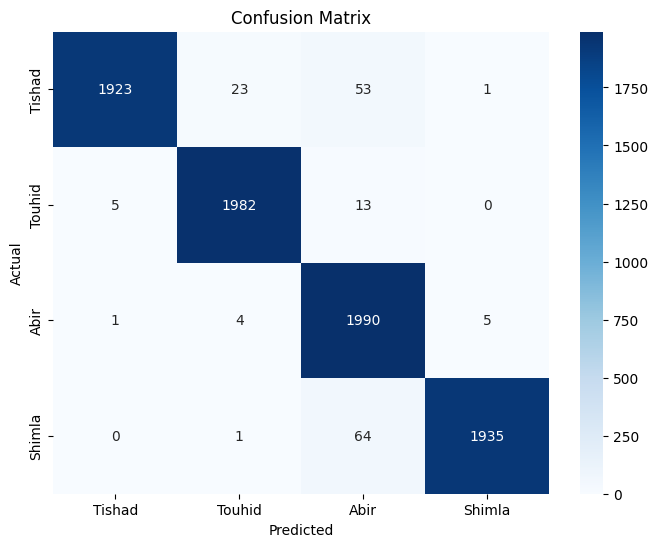

Classification Report:
              precision    recall  f1-score   support

      Tishad       1.00      0.96      0.98      2000
      Touhid       0.99      0.99      0.99      2000
        Abir       0.94      0.99      0.97      2000
      Shimla       1.00      0.97      0.98      2000

    accuracy                           0.98      8000
   macro avg       0.98      0.98      0.98      8000
weighted avg       0.98      0.98      0.98      8000



In [18]:
yPred = model.predict(xTrain)
yPredClasses = np.argmax(yPred, axis=1)

confMatrix = confusion_matrix(yTrain, yPredClasses)
plt.figure(figsize=(8, 6))
sns.heatmap(confMatrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:")
print(classification_report(yTrain, yPredClasses, target_names=labels))

In [19]:
accuracy = accuracy_score(yTrain, yPredClasses)
f1 = f1_score(yTrain, yPredClasses, average='weighted')
precision = precision_score(yTrain, yPredClasses, average='weighted')
recall = recall_score(yTrain, yPredClasses, average='weighted')
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")


Accuracy: 0.9788
F1 Score: 0.9789
Precision: 0.9796
Recall: 0.9788
